Import Library

In [ ]:
from keras.datasets import fashion_mnist, mnist
import matplotlib.pyplot as plt
import numpy as np

**Plotting various Categories of data**

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# MetaData of Fashion_Mnist dataset ...
CLASSES = {
  0:'T-shirt/top',
  1:'Trouser',
  2:'Pullover',
  3:'Dress',
  4:'Coat',
  5:'Sandal',
  6:'Shirt',
  7:'Sneaker',
  8:'Bag',
  9:'Ankle boot'
}

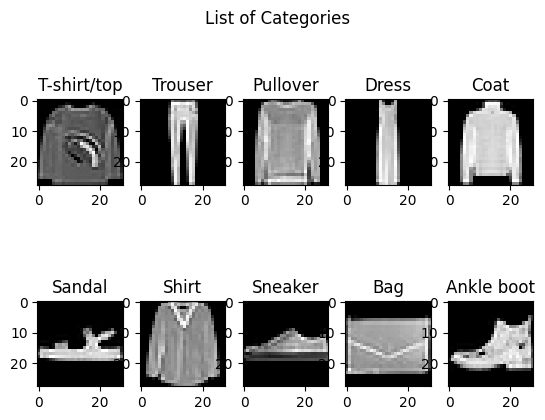

In [ ]:
ind_of_first_occurance = np.argsort(y_train)
ind = ind_of_first_occurance[np.searchsorted(y_train, np.arange(0,10,1), sorter=ind_of_first_occurance)]
fig, ax = plt.subplots(nrows=2, ncols=5)
for i in range(10):
  ax[i//5, i%5].imshow(x_train[ind[i]], cmap='gray')
  ax[i//5, i%5].set_title(CLASSES[i])

fig.suptitle('List of Categories')
plt.show()

In [ ]:
PARAMETERS = {
    'inpt_sz' : 784,
    'oupt_sz' : 10,
    'neurons' : 3,
    'hidden_lyrs' : 2,
    'activation' : 'sigmoid',
    'oupt_activation' : 'softmax',
    'dataset' : 'fashion_mnist',
    'loss_function': 'cross_entropy',
    'learning_rate': 0.1,
    'optimizer': 'sgd',
    'momentum': 0.9,
    'batch_sz': 100,
    'epochs': 10,
    'weight_initialisation': 'random'
}

In [ ]:
def load_data(dataset='fashion_mnist', purpose='train'):
  dataset=dataset.lower()
  purpose=purpose.lower()
  x,x_t,y,y_t = None,None,None,None

  if dataset == 'fashion_mnist':
    (x, y), (x_t, y_t) = fashion_mnist.load_data()
  elif dataset == 'mnist':
    (x, y), (x_t, y_t) = mnist.load_data()

  if purpose == 'train':
    x = x.reshape(x.shape[0], 784) / 255
    y = np.eye(10)[y]
    return x, y
  elif purpose == 'test':
    x_t = x_t.reshape(x_t.shape[0], 784) / 255
    y_t = np.eye(10)[y_t]
    return x_t, y_t

**Feed Forward Neural Net**

In [ ]:
class FF_NN:

  def __init__(self, param):
    self.hidden_layers = param['hidden_lyrs']
    self.neurons = param['neurons']
    self.input_neurons = param['inpt_sz'] # self.x_train.shape[1] * self.x_train.shape[2]
    self.output_neurons = param['oupt_sz'] # len(CLASSES)
    self.weights = []
    self.bias = []
    self.activation = param['activation']
    self.output_activation = param['oupt_activation']
    self.weight_initialisation = param['weight_initialisation']

    self.get_weights()
    self.get_bias()


  def get_bias(self):
    for _ in range(self.hidden_layers):
      self.bias.append(np.random.randn(self.neurons))
    self.bias.append(np.random.randn(self.output_neurons))

  def get_weights(self):
    if self.weight_initialisation.lower() == 'random':
      self.weights.append(np.random.randn(self.input_neurons, self.neurons))
      for _ in range(self.hidden_layers-1):
        self.weights.append(np.random.randn(self.neurons, self.neurons))
      self.weights.append(np.random.randn(self.neurons, self.output_neurons))

    else:
      limit = np.sqrt(6/(self.input_neurons + self.neurons))
      self.weights.append(np.random.uniform(low=-limit, high=limit, size=(self.input_neurons, self.neurons)))
      limit = np.sqrt(6/(self.neurons + self.neurons))
      for _ in range(self.hidden_layers-1):
        self.weights.append(np.random.uniform(low=-limit, high=limit, size=(self.neurons, self.neurons)))
      limit = np.sqrt(6/(self.neurons + self.output_neurons))
      self.weights.append(np.random.uniform(low=-limit, high=limit, size=(self.neurons, self.output_neurons)))


  def apply_activation(self, data):
    if self.activation.lower() == 'sigmoid':
      return 1/(1+np.exp(-data))
    elif self.activation.lower() == 'relu':
      return np.maximum(0,data)


  def apply_output_activation(self, data):
    if self.output_activation.lower() == 'softmax':
      data = np.exp(data)
      return data/np.sum(data,axis=1).reshape(data.shape[0],1)


  def feed_forward(self, input):
    self.A = [input]
    self.H = [input]

    # hidden layer calculations...
    for i in range(self.hidden_layers):
      self.A.append(self.bias[i] + np.matmul(self.H[-1], self.weights[i]))
      self.H.append(self.apply_activation(self.A[-1]))

    # output layer calculations...
    self.A.append(self.bias[-1] + np.matmul(self.H[-1], self.weights[-1]))
    self.H.append(self.apply_output_activation(self.A[-1]))

    return self.H[-1] # shape of H[-1] = 60000,10   shape of H = layers, 60000, neurons in each layer


In [ ]:
nn = FF_NN(PARAMETERS)
x_train, y_train = load_data(PARAMETERS['dataset'], 'train')
prediction = nn.feed_forward(x_train) # shape of xtrain -> 60000,784
print(prediction[0])

**Back_Propagation**

In [ ]:
class BP_NN:

  def __init__(
      self,
      ff_nn:FF_NN,
      param):
    self.ff_nn, self.loss, self.activation, self.output_activation = ff_nn, param['loss_function'], param['activation'], param['oupt_activation']

  def loss_derivative(self, y, y_pred):
    if self.loss == "cross_entropy":
      return -y / y_pred
    elif self.loss == "mse":
      return y_pred - y

  def activation_derivative(self, x):
    if self.activation == "sigmoid":
      return x * (1 - x)
    elif self.activation == "tanh":
      return 1 - x ** 2
    elif self.activation == "relu":
      return (x > 0).astype(int)
    elif self.activation == "identity":
      return np.ones(x.shape)

  def propogate_backward(self, y, y_pred):  # y=60000,10   y_pred=60000,10
    self.d_h, self.d_a, self.delta_weights, self.delta_bias = [], [], [], []

    self.d_a.append(y_pred-y)

    for i in range(self.ff_nn.hidden_layers, 0, -1):
      self.delta_weights.append(np.matmul(self.ff_nn.H[i].T, self.d_a[-1]))
      self.delta_bias.append(np.sum(self.d_a[-1], axis=0))
      self.d_h.append(np.matmul(self.d_a[-1], self.ff_nn.weights[i].T))
      self.d_a.append(self.d_h[-1] * self.activation_derivative(self.ff_nn.H[i]))

    self.delta_weights.append(np.matmul(self.ff_nn.H[0].T, self.d_a[-1]))
    self.delta_bias.append(np.sum(self.d_a[-1], axis=0))

    self.delta_weights.reverse()
    self.delta_bias.reverse()
    for i in range(len(self.delta_weights)):
      self.delta_weights[i] = self.delta_weights[i] / y.shape[0]
      self.delta_bias[i] = self.delta_bias[i] / y.shape[0]

    return self.delta_weights, self.delta_bias

**Optimizers**

In [ ]:
class Optimizer():
  def __init__(
      self,
      ff_nn: FF_NN,
      bp_nn: BP_NN,
      param
  ):
    self.ff_nn, self.bp_nn, self.lr, self.optimizer, self.momentum = ff_nn, bp_nn, param['learning_rate'], param['optimizer'], param['momentum']
    self.h_bias = [np.zeros_like(x) for x in self.ff_nn.bias]
    self.h_weights = [np.zeros_like(x) for x in self.ff_nn.weights]


  def optimize(self, delta_weights, delta_bias):
    if(self.optimizer == "sgd"):
      self.SGD(delta_weights, delta_bias)
    elif(self.optimizer == "momentum"):
      self.MGD(delta_weights, delta_bias)
    elif(self.optimizer == "nag"):
      self.NAGD(delta_weights, delta_bias)

  def SGD(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.ff_nn.weights[i] -= self.lr * (delta_weights[i])
      self.ff_nn.bias[i] -= self.lr * (delta_bias[i])


  def MGD(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.h_weights[i] = self.momentum * self.h_weights[i] + delta_weights[i]
      self.h_bias[i] = self.momentum * self.h_bias[i] + delta_bias[i]
      self.ff_nn.bias[i] -= self.lr * (self.h_bias[i])
      self.ff_nn.weights[i] -= self.lr * (self.h_weights[i])

  def NAG(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.h_weights[i] = self.momentum * self.h_weights[i]



In [1]:
def train(PARAMETERS):
    x_train, y_train = load_data('train', dataset=PARAMETERS['dataset'])
    np.random.seed(7)
    ff_nn = FF_NN(PARAMETERS)
    bp_nn = BP_NN(ff_nn, PARAMETERS)
    opt = Optimizer(ff_nn, bp_nn, PARAMETERS)
    # print(ff_nn.feed_forward(x_train))
    print("Initial Accuracy: {}".format(np.sum(np.argmax(ff_nn.feed_forward(x_train), axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0]))
    # x_train_act, x_val, y_train_act, y_val = train_test_split(x_train, y_train, test_size=0.1)
    # x_train_act=x_train
    # y_train_act=y_train
    batch_size = PARAMETERS['batch_sz']

    for epoch in range(PARAMETERS['epochs']):
      for i in range(0, x_train.shape[0], batch_size):
        y_batch = y_train[i:i+batch_size]
        x_batch = x_train[i:i+batch_size]
        y_pred = ff_nn.feed_forward(x_batch)
        weight_change, bias_change = bp_nn.propogate_backward(y_batch, y_pred)
        opt.optimize(weight_change, bias_change)

      y_pred = ff_nn.feed_forward(x_train)
      print("Epoch- {}, Accuracy- {}, Loss- {}".format(epoch + 1, loss(PARAMETERS['loss_function'], np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0], y_train, y_pred)))

    return ff_nn
